<a href="https://colab.research.google.com/github/edwardliu24/RNN-stock-market-prediction/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import math
import pandas_datareader as web
import numpy as np
from numpy  import array
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import csv
from google.colab import files
import io
import tensorflow as tf

In [30]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['AIndexEodPrices.csv']),index_col=0)


Saving AIndexEodPrices.csv to AIndexEodPrices (1).csv


In [31]:
del df['S_INFO_WINDCODE']
df = df[df['TRADE_DT']<20220501]

In [32]:
df

,TRADE_DT,S_DQ_CLOSE
0,20100104,3535.2290
1,20100105,3564.0380
2,20100106,3541.7270
3,20100107,3471.4560
4,20100108,3480.1300
...,...,...
2989,20220425,3814.9127
2990,20220426,3784.1198
2991,20220427,3895.5361
2992,20220428,3921.1073


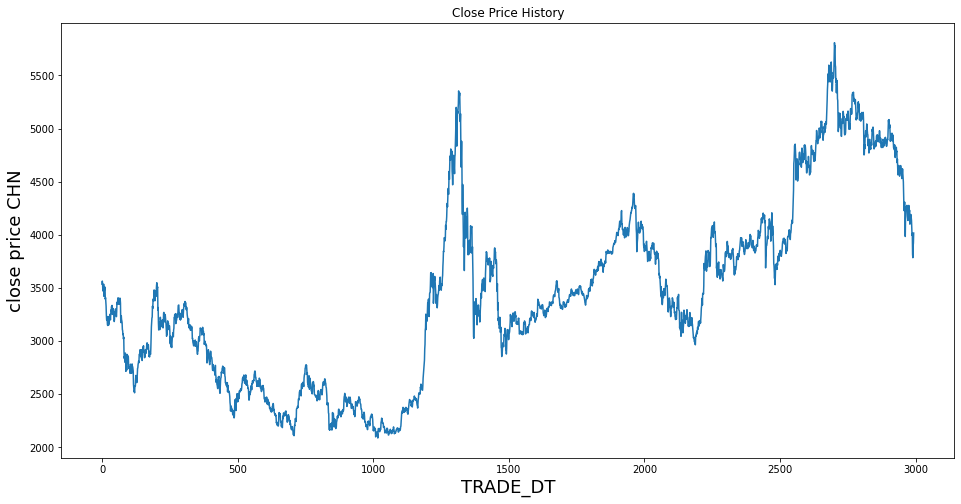

In [33]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['S_DQ_CLOSE'])
plt.xlabel('TRADE_DT',fontsize=18)
plt.ylabel('close price CHN',fontsize=18)
plt.show()

In [34]:
training_set = df.iloc[:len(df)//4*3 , 1:2].values  
test_set = df.iloc[len(df)//4*3:, 1:2].values  
#将数据归一化，范围是0到1
sc  = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled  = sc.transform(test_set) 
n_timestamp  = 60 

# 取前 n_timestamp 天的数据为 X；n_timestamp+1天数据为 Y。
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        
        if end_ix > len(sequence)-1:
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



In [35]:

X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_test, y_test   = data_split(testing_set_scaled, n_timestamp)

In [36]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
history = model.fit(X_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
2184/2184 [==============================] - 16s 7ms/step - loss: 0.0021
Epoch 2/20
2184/2184 [==============================] - 14s 6ms/step - loss: 8.0825e-04
Epoch 3/20
2184/2184 [==============================] - 15s 7ms/step - loss: 5.6199e-04
Epoch 4/20
2184/2184 [==============================] - 15s 7ms/step - loss: 4.7402e-04
Epoch 5/20
2184/2184 [==============================] - 14s 6ms/step - loss: 4.8249e-04
Epoch 6/20
2184/2184 [==============================] - 14s 6ms/step - loss: 4.4550e-04
Epoch 7/20
2184/2184 [==============================] - 14s 7ms/step - loss: 3.9255e-04
Epoch 8/20
2184/2184 [==============================] - 14s 6ms/step - loss: 3.9125e-04
Epoch 9/20
2184/2184 [==============================] - 14s 6ms/step - loss: 3.8863e-04
Epoch 10/20
2184/2184 [==============================] - 14s 6ms/step - loss: 3.9525e-04
Epoch 11/20
2184/2184 [==============================] - 14s 6ms/step - loss: 4.1047e-04
Epoch 12/20
2184/2184 [===========

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


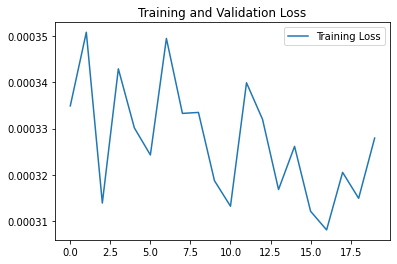

23/23 [==============================] - 0s 5ms/step


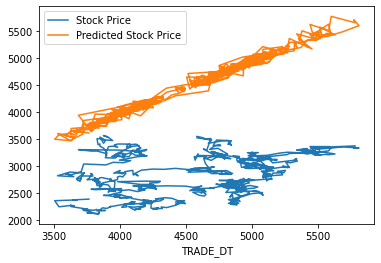

In [16]:
model.summary()

plt.plot(history.history['loss']    , label='Training Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


predicted_stock_price = model.predict(X_test)                        # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price      = sc.inverse_transform(y_test)# 对真实数据还原---从（0，1）反归一化到原始范围



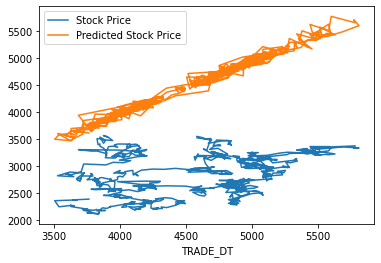

In [17]:
plot_df = pd.DataFrame()
plot_df['TRADE_DT'] = df.iloc[len(df)//4*3 + n_timestamp:, 1].tolist()
plot_df['Stock Price'] = df['S_DQ_CLOSE']
plot_df['Predicted Stock Price'] = predicted_stock_price

plot_df.plot(x = 'TRADE_DT',y = ['Stock Price','Predicted Stock Price'])



23/23 [==============================] - 0s 4ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


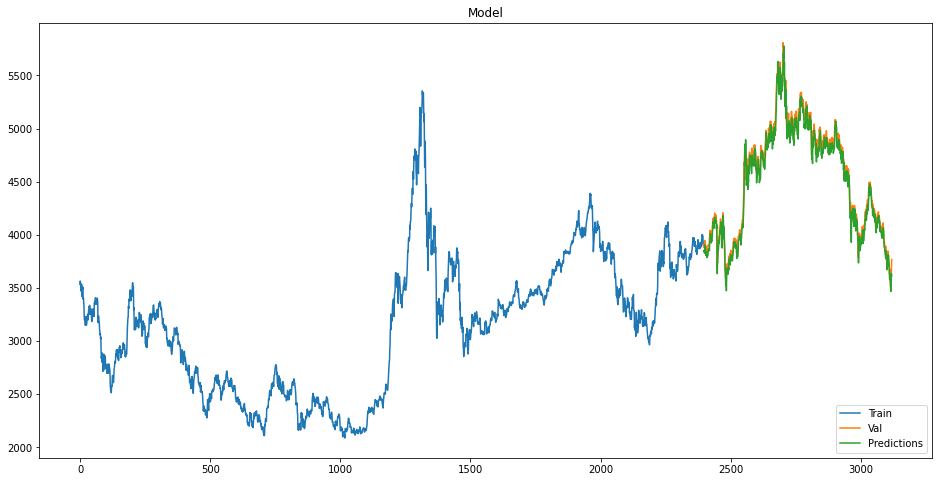

In [22]:
train = df[:len(df)//4*3+60]
valid = df[len(df)//4*3+60:]
predictions = model.predict(X_test)
predictions = sc.inverse_transform(predictions)
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.plot(train['S_DQ_CLOSE'])
plt.plot(valid[['S_DQ_CLOSE', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [51]:
uploaded = files.upload()
df2 = pd.read_csv(io.BytesIO(uploaded['AIndexEodPrices.csv']),index_col=0)


Saving AIndexEodPrices.csv to AIndexEodPrices (3).csv


In [53]:
df2 = df2[df2['TRADE_DT']>=20220501]
del df2['S_INFO_WINDCODE']

In [54]:
realstockprice=df2.iloc[:,1:2].values
unseendata = sc.fit_transform(realstockprice)
X_new = []
for i in range(60,len(unseendata)):
  X_new.append(unseendata[i-60:i,0])
X_new=np.array(X_new)
X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))
forcast_stock_price = model.predict(X_new)
forcast_stock_price =sc.inverse_transform(forcast_stock_price)

3/3 [==============================] - 0s 6ms/step


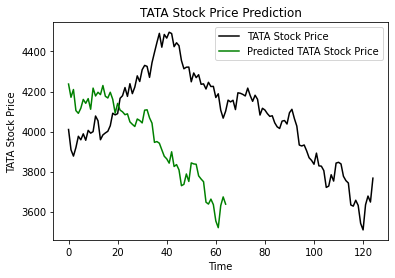

In [55]:
plt.plot(realstockprice, color = 'black', label = 'TATA Stock Price')
plt.plot(forcast_stock_price, color = 'green', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()